In [128]:
import os
import glob

from tqdm import tqdm

import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import sys
import platform
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.Plot as hPlot
import HydroAI.Grid as hGrid
import HydroAI.Data as hData
import HydroAI.LULC as hLULC
importlib.reload(hGrid);
importlib.reload(hPlot);
importlib.reload(hData);

In [2]:
base_dir = "/Users/hyunglokkim/cpuserver_data/CYGNSS/L1_V21"
nc_file_list = hData.get_file_list(base_dir, 'nc4')

In [42]:
#ref_lon, ref_lat = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')
ref_lon, ref_lat = hGrid.generate_lon_lat_e2grid('36km')
#ref_lon, ref_lat = hGrid.generate_lon_lat_eqdgrid(0.25)

data_count = np.zeros_like(ref_lat, dtype=int)
# Flatten the reference arrays and stack them as [latitude, longitude]
ref_points = np.column_stack((ref_lat.flatten(), ref_lon.flatten()))
tree = cKDTree(ref_points)

Processing row 0/406
Processing row 100/406
Processing row 200/406
Processing row 300/406
Processing row 400/406


(406, 964)

In [176]:
# Initialize arrays for accumulating sums and counts
angle_sum = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
angle_sum_sq = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
data_count = np.zeros_like(ref_lat, dtype=int)  # Count of measurements for each grid cell

for i, file_name in tqdm(enumerate(nc_file_list[:10]), total=len(nc_file_list[:10]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sp_inc_angle = dataset.variables['sp_inc_angle'][:].flatten().compressed()
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)
    
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    # Update sums, sum of squares, and counts for each point
    for row, col, angle in zip(rows, cols, sp_inc_angle):
        #row = 66
        angle_sum[row, col] += angle
        angle_sum_sq[row, col] += angle ** 2
        data_count[row, col] += 1

Processing Files: 100%|█████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


In [182]:
import pandas as pd
from pathlib import Path

# Define the list of resolution values
resol_values = ["3km", "9km", "25km", "36km"]

# Dictionary to store data for each resolution
data_dict = {}

# Iterate over each resolution value
for resol in resol_values:
    # Get file paths
    data_counts_file = hData.get_file_list(cpuserver_data_FP+'/CYGNSS/data_counts_csv', 'csv', filter_strs=["data_count_"+resol+".csv"])[0]
    angle_sum_file = hData.get_file_list(cpuserver_data_FP+'/CYGNSS/data_counts_csv', 'csv', filter_strs=["angle_sum_"+resol+".csv"])[0]
    angle_sum_sq_file = hData.get_file_list(cpuserver_data_FP+'/CYGNSS/data_counts_csv', 'csv', filter_strs=["angle_sum_sq_"+resol+".csv"])[0]

    # Read data from files
    data_counts = pd.read_csv(data_counts_file, header=None).values
    angle_sum = pd.read_csv(angle_sum_file, header=None).values
    angle_sum_sq = pd.read_csv(angle_sum_sq_file, header=None).values

    # Generate lon and lat
    lon, lat = hGrid.generate_lon_lat_e2grid(resol)

    # Create dictionary to store data
    data_dict[resol] = {
        "data_counts": data_counts,
        "angle_sum": angle_sum,
        "angle_sum_sq": angle_sum_sq,
        "lon": lon,
        "lat": lat
    }

Processing row 0/4872
Processing row 100/4872
Processing row 200/4872
Processing row 300/4872
Processing row 400/4872
Processing row 500/4872
Processing row 600/4872
Processing row 700/4872
Processing row 800/4872
Processing row 900/4872
Processing row 1000/4872
Processing row 1100/4872
Processing row 1200/4872
Processing row 1300/4872
Processing row 1400/4872
Processing row 1500/4872
Processing row 1600/4872
Processing row 1700/4872
Processing row 1800/4872
Processing row 1900/4872
Processing row 2000/4872
Processing row 2100/4872
Processing row 2200/4872
Processing row 2300/4872
Processing row 2400/4872
Processing row 2500/4872
Processing row 2600/4872
Processing row 2700/4872
Processing row 2800/4872
Processing row 2900/4872
Processing row 3000/4872
Processing row 3100/4872
Processing row 3200/4872
Processing row 3300/4872
Processing row 3400/4872
Processing row 3500/4872
Processing row 3600/4872
Processing row 3700/4872
Processing row 3800/4872
Processing row 3900/4872
Processing r

In [186]:
# Example usage: Accessing data_dict for resolution "36km"
counts_36 = data_dict["36km"]["data_counts"]
sum_36 = data_dict["36km"]["angle_sum"]
sum_sq_36 = data_dict["36km"]["angle_sum_sq"]
lat_36 = data_dict["36km"]["lat"]
lon_36 = data_dict["36km"]["lon"]

counts_25 = data_dict["25km"]["data_counts"]
sum_25 = data_dict["25km"]["angle_sum"]
sum_sq_25 = data_dict["25km"]["angle_sum_sq"]
lat_25 = data_dict["25km"]["lat"]
lon_25 = data_dict["25km"]["lon"]

counts_9 = data_dict["9km"]["data_counts"]
sum_9 = data_dict["9km"]["angle_sum"]
sum_sq_9 = data_dict["9km"]["angle_sum_sq"]
lat_9 = data_dict["9km"]["lat"]
lon_9 = data_dict["9km"]["lon"]

counts_3 = data_dict["3km"]["data_counts"]
sum_3 = data_dict["3km"]["angle_sum"]
sum_sq_3 = data_dict["3km"]["angle_sum_sq"]
lat_3 = data_dict["3km"]["lat"]
lon_3 = data_dict["3km"]["lon"]

FP = cpuserver_data_FP + '/LULC/MCD12C1/'
file_list =  hData.get_file_list(FP, 'hdf')
input_file = file_list[-1]
MCD12C1_t1 = hData.read_hdf4_variable(input_file, 'Majority_Land_Cover_Type_1')
lon_eqd_5km, lat_eqd_5km = hGrid.generate_lon_lat_eqdgrid(0.05)

LULC_36 = hData.Resampling(lat_36, lon_36, lat_eqd_5km, lon_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=3)
LULC_25 = hData.Resampling(lat_25, lon_25, lat_eqd_5km, lon_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=3)
LULC_9  = hData.Resampling(lat_9,  lon_9,  lat_eqd_5km, lon_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=3)
LULC_3  = hData.Resampling(lat_3,  lon_3,  lat_eqd_5km, lon_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=5)

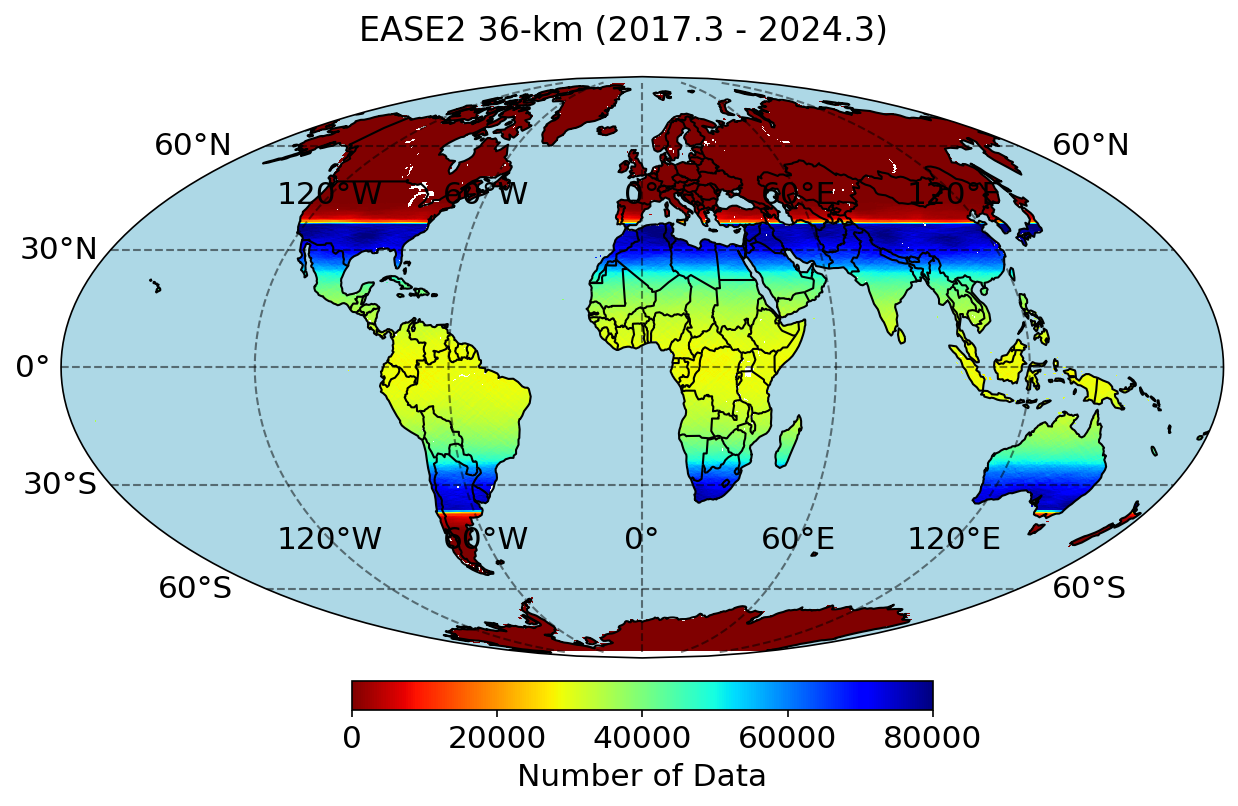

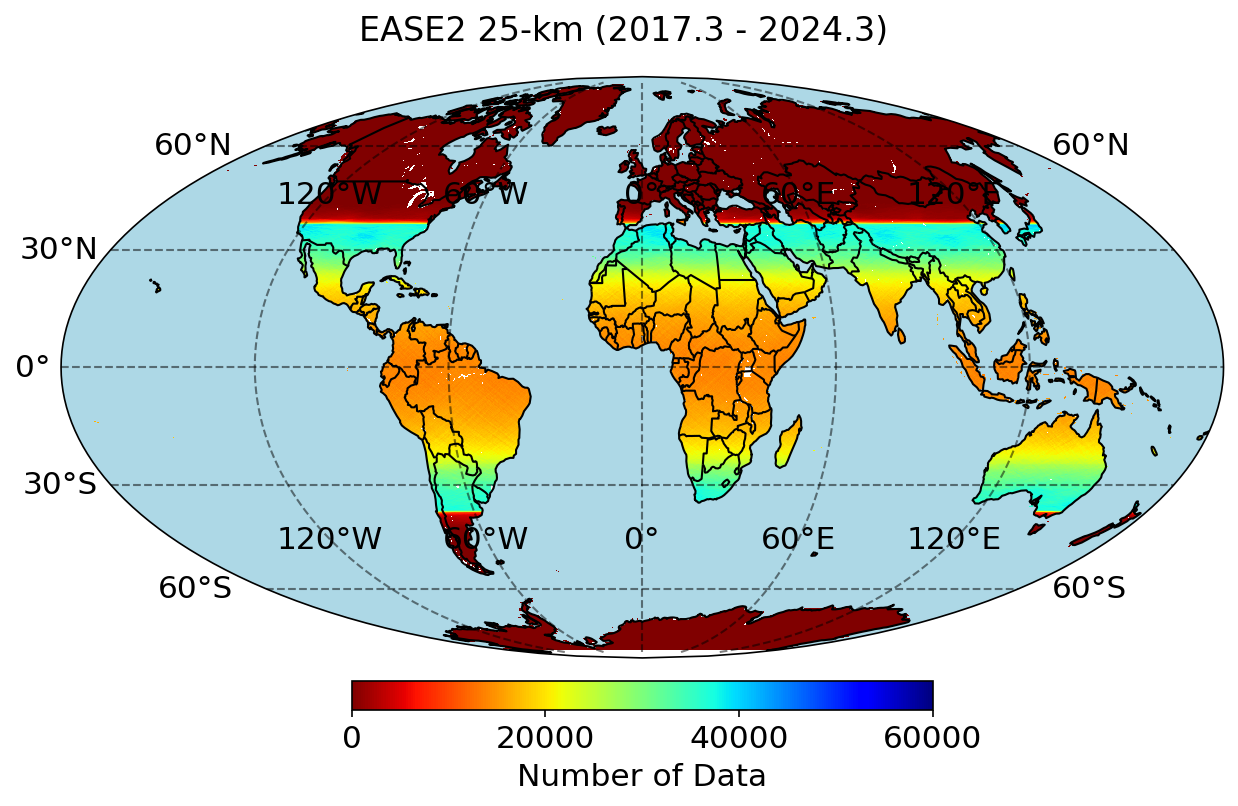

In [211]:
def calculate_and_plot(data_counts, angle_sum, angle_sum_sq, lon, lat, LULC, resol):
    """
    Calculate the inclination angle and standard deviation, then plot the data on a map.

    Args:
    - data_counts: Data counts.
    - angle_sum: Angle sum.
    - angle_sum_sq: Angle sum squared.
    - lon: Longitudes.
    - lat: Latitudes.
    - LULC: Land use land cover data.

    Returns:
    - None
    """
    # Calculate inclination angle average
    with np.errstate(divide='ignore', invalid='ignore'):
        inc_avg = angle_sum / data_counts
        inc_std = angle_sum_sq / data_counts - (angle_sum / data_counts) ** 2
        inc_std[data_counts == 0] = np.nan  # Set where denominator is zero to NaN

    # Prepare data for plotting
    val = data_counts.copy()
    val[LULC == 0] = np.nan

    # Plot the data on a map
    importlib.reload(hPlot)
    if resol == '36':
        max_val = 80000
    elif resol == '25':
        max_val = 60001
    elif resol == '9':
        max_val = 60000
    elif resol == '3':
        max_val = 2000
    
    hPlot.plot_map(lon, lat, val, 0, max_val, plot_title='EASE2 '+resol+'-km (2017.3 - 2024.3)',
                   label_title='Number of Data', cmap='jet_r', projection='Mollweide')

# Example usage:
# Assuming you have the necessary inputs defined
calculate_and_plot(counts_36, sum_36, sum_sq_36, lon_36, lat_36, LULC_36, '36')
calculate_and_plot(counts_25, sum_25, sum_sq_25, lon_25, lat_25, LULC_25, '25')
#calculate_and_plot(counts_9, sum_9, sum_sq_9, lon_9, lat_9, LULC_9, '9')
#calculate_and_plot(counts_3, sum_3, sum_sq_3, lon_3, lat_3, LULC_3, '3')